## PortfolioTimeSeries.ipynb

Code for the Chicago Booth course on Quantitative Portfolio Management by Ralph S.J. Koijen and (current and former) teaching assistants Sangmin Oh, Federico Mainardi, and Laurenz de Rosa.

### Preliminaries

This code builds time-series portfolio strategies. *This notebook also contains the questions for problem set 2.*
- As always, the data can be found in the dropbox folder: https://www.dropbox.com/scl/fo/ze2tut4prlptuyhuyofx4/AI7wV4q-6e-KDBSnRhyJptI?rlkey=93yaxhwrk0w8drx5d7o71cvow&dl=0. 
- Please download the file `ETFdata_small.parquet`. 

We first load several packages to initialize Python.

In [31]:
import statsmodels.api as sm
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import wrds
import qpm
import qpm_download

pd.options.mode.chained_assignment = None

Select wether you would like to download data directly from WRDS (`import_data` = True) or to load data from Dropbpx (`import_data` = False). If you decide to load data from Dropbox, make sure to define the data directoy (`_DATA_DIR`).

In [32]:
import_data = False            # <-- Edit this line
_DATA_DIR = 'Data'       # <-- Edit this line

We can select the sample period and ticker here. We select an ETF covering the financial sector (ticker: XLF) and the S&P500 (ticker: SPY). To keep the data files initially small so that the code runs quickly, the file only contains two tickers. 

However, we can adjust this to any ticker. The file `ETFdata.parquet` contains thousands of ETFs, and these data you could explore for your final project. This may be relevant for your final project as ETFs allow you to explore other assets classes, industries, or countries. For an overview of available ETFs, you can for instance visit this website: https://etfdb.com/etfs/. 

In [33]:
# Select the sample period
_SAMPLE_START = '2005-01-01'
_SAMPLE_END = '2024-08-31'

# Select the ticker
_ETF_TICKER = 'SPY'

Now we're ready to start!

### Step 1. Load Data

We first load the *daily* ETF data and we store it in `df_ETF`. If you selected import_data = True, the code will donwload and construct the data directly from WRDS. Otherwise, the code will import data from the Dropbox folder.

In [34]:
if import_data == True: 
    
    df_ETF_raw = qpm_download.time_series(_SAMPLE_START, _SAMPLE_END)
        
if import_data == False:
    
    # Load the data
    df_ETF_raw = pd.read_parquet('%s/ETFdata_small.parquet' %(_DATA_DIR))
    

For each ETF, we have the daily return, `retd`, and the return of that month, `retM`. We use the daily return to compute the standard deviation below. The variable `date` is the daily date; the variable `ym` is the year and month. 

The factors (`mktrf` = excess return on the market, `smb` = the Fama and French size factor, `hml` = the Fama and French value factor, `rf` = the risk-free rate, `umd` = the momentum factor) are all *monthly* returns. We also include the `CPI`, `inflation`, and `yr5breakeven`, which is the 5-year break-even inflation rate. We include those in case you like to explore strategies related to inflation risk, which is an important theme in the industry at the moment.

In [35]:
# Select the ETF using the ticker symbol
df_ETF = df_ETF_raw[df_ETF_raw['ticker'] == _ETF_TICKER]

# Select the relevant variables for our strategy
df_ETF = df_ETF[['date','ym','retd','retM','mktrf','rf']]

# Sort the data
df_ETF.sort_values(['date'], inplace = True)

# Print the data 
print(df_ETF.head(3))
print(df_ETF.tail(3))

        date         ym      retd      retM   mktrf     rf
0 2003-01-02 2003-01-01  0.032189 -0.024595 -0.0257  0.001
3 2003-01-03 2003-01-01  0.003075 -0.024595 -0.0257  0.001
4 2003-01-06 2003-01-01  0.017625 -0.024595 -0.0257  0.001
            date         ym      retd      retM   mktrf     rf
10941 2024-09-26 2024-09-01  0.003965  0.020979  0.0174  0.004
10943 2024-09-27 2024-09-01 -0.001450  0.020979  0.0174  0.004
10944 2024-09-30 2024-09-01  0.004007  0.020979  0.0174  0.004


### Step 2. Portfolio Construction

To compute the standard deviation, there are two steps that are combined into a single line of code. 

- We take the column `retd`, which are the daily returns, and we select the data for a given month, that is, `ym`. This is the part `groupby(['ym'])['retd']`. 
- Using the daily returns in a given month, we compute the standard deviation. This is done by `transform(lambda x : x.std())`. We then store the data in a new column, labeled `sd`.

In [36]:
df_ETF['sd'] = df_ETF.groupby(['ym'])['retd'].transform(lambda x : x.std())
print(df_ETF.head(3))
print(df_ETF.tail(3))

        date         ym      retd      retM   mktrf     rf        sd
0 2003-01-02 2003-01-01  0.032189 -0.024595 -0.0257  0.001  0.014983
3 2003-01-03 2003-01-01  0.003075 -0.024595 -0.0257  0.001  0.014983
4 2003-01-06 2003-01-01  0.017625 -0.024595 -0.0257  0.001  0.014983
            date         ym      retd      retM   mktrf     rf        sd
10941 2024-09-26 2024-09-01  0.003965  0.020979  0.0174  0.004  0.008584
10943 2024-09-27 2024-09-01 -0.001450  0.020979  0.0174  0.004  0.008584
10944 2024-09-30 2024-09-01  0.004007  0.020979  0.0174  0.004  0.008584


We now want to convert the daily data to monthly data. 
- We keep the first observation for each month (`ym`). The part `.first()` keep the first observation for each month.

In [37]:
df = df_ETF.groupby(['ym'])[['ym', 'retM', 'sd', 'mktrf', 'rf']].first()
print(df.head(3))

                   ym      retM        sd   mktrf      rf
ym                                                       
2003-01-01 2003-01-01 -0.024595  0.014983 -0.0257  0.0010
2003-02-01 2003-02-01 -0.013479  0.011635 -0.0188  0.0009
2003-03-01 2003-03-01  0.002289  0.016972  0.0109  0.0010


We can only form portfolios based on information that we know in advance. For instance, for the portfolio that we hold in January 2023, we can only use data that we know in December 2022. We therefore lag the volatility signal by one period. 
- We compute the lag, using `shift` as we have seen in the mean-variance problem set. We then annualize the standard deviation by the square root of the number of trading days, $\sqrt{252}$.


In [38]:
df['Lsd'] = df['sd'].shift(1) * np.sqrt(252)
print(df.head(3))

                   ym      retM        sd   mktrf      rf       Lsd
ym                                                                 
2003-01-01 2003-01-01 -0.024595  0.014983 -0.0257  0.0010       NaN
2003-02-01 2003-02-01 -0.013479  0.011635 -0.0188  0.0009  0.237842
2003-03-01 2003-03-01  0.002289  0.016972  0.0109  0.0010  0.184699


There is one missing value created, but we will take care of this in constructing the portfolio weights.

We are now ready to compute the portfolio weight as
$$w(t) = \min\left\{\frac{c}{\sigma_t},2\right\},$$
where $c$ is a scaling factor. It determines the amount of risk we'd like to take. Higher values of $c$ correspond to riskier strategies. We want to have an average $\beta$ of about 1. We choose $c=1.25 \times \overline{\sigma_t}$, where $\overline{\sigma_t}$ is the average volatility, $\sigma_t$. We take 1.25 so that the average $\beta$ is around one. We take the minimum of $\frac{c}{\sigma_t}$ and 2 to avoid that the portfolio gets too extreme during low volatility periods. 

The code has three steps
1. Compute the scaling $c$.
2. Compute the portfolio weight. Note that in computing the portfolio weight, it ends with `fillna(1)`. This means that missing portfolio weights (caused by the missing value of the standard deviation above) are replaced with 1, that is, invest all capital in the ETF.
3. In the final step, we drop the data from the standard deviation (`sd`), the lagged standard deviation (`Lsd`) and the scaling factor (`c`), as we no longer need those for the remainder of the code.

In [39]:
df['c'] = 1.25 * df['Lsd'].mean()
df['weight'] = df.apply(lambda x : min(x['c'] / x['Lsd'], 2), axis = 1).fillna(1)
df.drop(columns = ['sd','Lsd', 'c'], inplace = True)
print(df.head(3))

                   ym      retM   mktrf      rf    weight
ym                                                       
2003-01-01 2003-01-01 -0.024595 -0.0257  0.0010  1.000000
2003-02-01 2003-02-01 -0.013479 -0.0188  0.0009  0.813066
2003-03-01 2003-03-01  0.002289  0.0109  0.0010  1.047004


We can now compute the return on the portfolio
$$r_p(t) = w(t) r_{ETF}(t)+[1-w(t)]r_f(t).$$
The first line computes the raw return, and the next two lines compute the excess return by subtracting the risk-free rate.

In [40]:
# Returns on the volatility timing strategy
df['retP'] = df['weight'] * df['retM'] + (1 - df['weight']) * df['rf']

# Excess returns on the volatility timing strategy
df['reteP'] = df['retP'] - df['rf']

# Excess returns on the ETF itself (without volatility timing)
df['reteM'] = df['retM'] - df['rf']

# Drop the risk-free rate from the data as we no longer need it
df.drop(columns = ['rf'], inplace = True)
print(df.head(3))

                   ym      retM   mktrf    weight      retP     reteP  \
ym                                                                      
2003-01-01 2003-01-01 -0.024595 -0.0257  1.000000 -0.024595 -0.025595   
2003-02-01 2003-02-01 -0.013479 -0.0188  0.813066 -0.010791 -0.011691   
2003-03-01 2003-03-01  0.002289  0.0109  1.047004  0.002350  0.001350   

               reteM  
ym                    
2003-01-01 -0.025595  
2003-02-01 -0.014379  
2003-03-01  0.001289  


We are done building the strategy! Let's analyze the returns now.

### Step 3. Portfolio Analytics

We first select the sample period that we would like to study.

In [41]:
df = df[(df['ym'] >= _SAMPLE_START) & (df['ym'] <= _SAMPLE_END)]
print(df.head(3))

                   ym      retM   mktrf    weight      retP     reteP  \
ym                                                                      
2005-01-01 2005-01-01 -0.022421 -0.0276  2.000000 -0.046442 -0.048042   
2005-02-01 2005-02-01  0.020904  0.0189  1.926270  0.038785  0.037185   
2005-03-01 2005-03-01 -0.018262 -0.0197  1.791328 -0.034375 -0.036475   

               reteM  
ym                    
2005-01-01 -0.024021  
2005-02-01  0.019304  
2005-03-01 -0.020362  


Let's plot the portfolio weights to see what the strategy does.

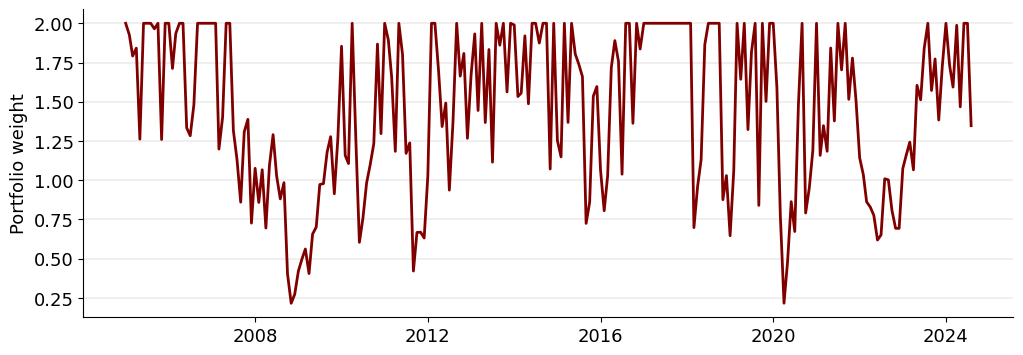

In [42]:
fig, ax = plt.subplots()
ax.plot(df['ym'], df['weight'], linewidth=2.0)
plt.ylabel('Date')
plt.ylabel('Portfolio weight')
plt.show()

Plot cumulative returns:

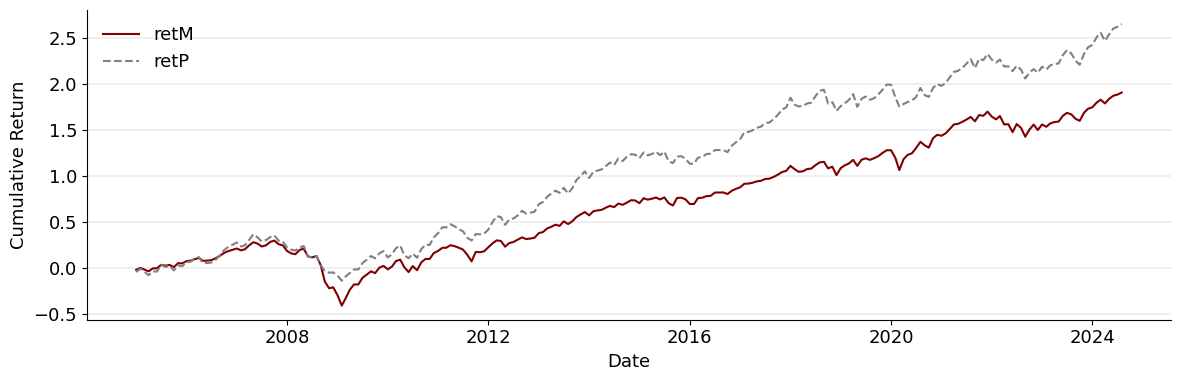

In [43]:
qpm.plot_cumulative_returns_etf(df, var_list = ['retM', 'retP'])

The next block computes the *annualized* average return, the standard deviation, and Sharpe ratio for each of the strategies.

In [44]:
# Compute summary statistics, and only keep the mean and the standard deviation
summary = df[['reteM', 'reteP']].describe().T[['mean', 'std']]

# Annualize the mean
summary['mean'] = summary['mean'] * 12

# Annualize the standard deviation
summary['std'] = summary['std'] * np.sqrt(12)

# Compute the Sharpe ratio
summary['sr'] = summary['mean'] / summary['std']

# Print the mean, standard deviation, and Sharpe ratio
print(summary.round(3))

        mean    std     sr
reteM  0.094  0.151  0.624
reteP  0.136  0.176  0.777


Now let's see whether the strategy using `SPY` generates alpha. We use the market excess return as our benchmark. You can change the end of the sample by modifying the date `2019-12-01`. In the first case, we stop before 2020.

In [45]:
# Select the sample
reg_df_select = df[df['ym'] <= '2019-12-31']

# Run a regression of reteP (the excess return on the vol timed strategy) on the excess return of the market
print(sm.OLS(reg_df_select['reteP'], sm.add_constant(reg_df_select['mktrf'])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  reteP   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     654.9
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           1.52e-61
Time:                        14:00:01   Log-Likelihood:                 432.68
No. Observations:                 180   AIC:                            -861.4
Df Residuals:                     178   BIC:                            -855.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      2.348      0.0

Let's interpret the output. There are 180 observations, that is, 180 months. The constant is the alpha, and it equals 0.39% per month. This implies an annual alpha of 12 * 0.39 = 4.68%. The corresponding t-statistic is 2.35. This implies that the alpha is signifficantly positive at conventional levels (-1.96 and 1.96 are the usual cutoffs).

The beta is 1.02 (the coefficient corresponding to mktrf). It is also highly significant. Hence, we here have a strategy that simply times the market based on volatility and it generates an alpha of almost 5% a year. 

# Question 1

Run the same regression but now including the data in 2020 and 2021. Copy the code in the previous cell and change the date to `2021-12-30`. How does the performance change and what is the economic interpretation?

In [46]:
## Insert your code here (part A)
# Select the sample
reg_df_select = df[df['ym'] <= '2021-12-30']

# Run a regression of reteP (the excess return on the vol timed strategy) on the excess return of the market
print(sm.OLS(reg_df_select['reteP'], sm.add_constant(reg_df_select['mktrf'])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  reteP   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     664.2
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           8.86e-66
Time:                        14:00:40   Log-Likelihood:                 473.05
No. Observations:                 204   AIC:                            -942.1
Df Residuals:                     202   BIC:                            -935.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.886      0.0

In [ ]:
#The positive alpha indicates that the strategy might still add value beyond market exposure, but the reduced t-statistic (1.886) suggests weaker confidence in this finding. 
#The beta's high significance reinforces that the portfolio is market-driven, with minimal deviations in systematic risk.

Now let's run the same regression until the end of the sample. Copy the code in the previous cell and change the date to `_SAMPLE_END`. How does the performance change and what is the economic interpretation?

In [47]:
## Insert your code here (part B)
# Select the sample
reg_df_select = df[df['ym'] <= _SAMPLE_END]

# Run a regression of reteP (the excess return on the vol timed strategy) on the excess return of the market
print(sm.OLS(reg_df_select['reteP'], sm.add_constant(reg_df_select['mktrf'])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  reteP   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     865.7
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           1.37e-80
Time:                        14:07:49   Log-Likelihood:                 552.05
No. Observations:                 236   AIC:                            -1100.
Df Residuals:                     234   BIC:                            -1093.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      2.179      0.0

In [ ]:
#The portfolio behaves like the market in terms of systematic risk exposure but still manages to generate alpha.
# The β>1 (slightly above 1) suggests the portfolio is marginally more sensitive to market movements than the average market portfolio.

Now let's explore the financial markets ETF. We change the ticker to `XLF` and run the same code as before. We collect the relevant code in the cell below. You can run it without modifications.

In [48]:
# Re-run the code from above but now for XLF

_ETF_TICKER = 'XLF'

# Load the data 
df_ETF = df_ETF_raw[df_ETF_raw['ticker'] == _ETF_TICKER]
df_ETF.sort_values(['date', 'ym'], inplace = True)

# Compute the standard deviation
df_ETF['sd'] = df_ETF.groupby(['ym'])['retd'].transform(lambda x : x.std())

# Select one observation per month
df = df_ETF.groupby(['ym'])[['retM', 'sd', 'ym', 'rf', 'mktrf']].first()

# Compute the lagged standard deviation 
df['Lsd'] = df['sd'].shift(1) * np.sqrt(252)

# Compute the scaling
df['c'] = 1.25 * df['Lsd'].mean()

# Compute the portfolio weight
df['weight'] = df.apply(lambda x : min(x['c'] / x['Lsd'], 2), axis = 1).fillna(1)

# Compute strategy returns, excess strategy returns, and the excess return on the ETF itself
df['retP'] = df['weight'] * df['retM'] + (1 - df['weight']) * df['rf']
df['reteP'] = df['retP'] - df['rf']
df['reteM'] = df['retM'] - df['rf']

# Select the sample
df = df[(df['ym'] >= _SAMPLE_START) & (df['ym'] <= _SAMPLE_END)]

reg_df_select = df

print("Done rebuilding the data...")

Done rebuilding the data...


Recall that `reteM` is the excess return on the untimed ETF. We first measure the performance of this ETF, untimed, by regressing it on the benchmark. 

In [49]:
# Regress the ETF excess return (untimed) on the excess return on the market
print(sm.OLS(reg_df_select['reteM'], sm.add_constant(reg_df_select['mktrf'])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  reteM   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     634.9
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           1.33e-68
Time:                        14:10:14   Log-Likelihood:                 470.78
No. Observations:                 236   AIC:                            -937.6
Df Residuals:                     234   BIC:                            -930.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045      0.002     -2.067      0.0

The underperformance is quite large. The alpha is -0.45% per month, or -5.4% per year. The alpha is statistically significant. Now let's explore whether volatility timing helps. 

# Question 2

Consider a performance regression of the volatility-timed XLF using the same benchmark, as before. For the sample, we can use the full sample. Describe the results.

In [50]:
# Select the sample
reg_df_select = df[df['ym'] <= _SAMPLE_END]

# Run a regression of reteP (the excess return on the vol timed strategy) on the excess return of the market
print(sm.OLS(reg_df_select['reteP'], sm.add_constant(reg_df_select['mktrf'])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  reteP   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     293.0
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           3.85e-43
Time:                        14:10:41   Log-Likelihood:                 375.26
No. Observations:                 236   AIC:                            -746.5
Df Residuals:                     234   BIC:                            -739.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.023e-05      0.003     -0.018      0.9

In [ ]:
#The alpha is effectively zero (statistically and practically), meaning the portfolio does not generate excess return beyond what the market explains.
#The beta is significantly greater than 1, suggesting the portfolio is taking on higher market risk.


# Question 3
Repeat this exercise, but now using the untimed XLF returns as the benchmark, and the full sample. Describe the economic and statistical significance of the results. For which investors would the results in this analysis be particularly relevant?

In [52]:

# Select the sample
reg_df_select = df[df['ym'] <= _SAMPLE_END]

# Run a regression of reteP (the excess return on the vol timed strategy) on the excess return of the untimed XLF
print(sm.OLS(reg_df_select['reteP'], sm.add_constant(reg_df_select['reteM'])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  reteP   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     610.6
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           3.70e-67
Time:                        14:14:24   Log-Likelihood:                 430.90
No. Observations:                 236   AIC:                            -857.8
Df Residuals:                     234   BIC:                            -850.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.003      1.828      0.0

In [ ]:
#The annualized alpha of 5.64% is meaningful for an investment strategy. 
#However, the t-statistic (1.828) indicates that the result is not robustly significant at conventional levels but still suggests potential value creation.
#The beta of 0.9926 confirms the portfolio closely mirrors the market in systematic risk while attempting to generate alpha.

#This portfolio would be particularly appealing to risk-averse or market-neutral investors who are looking for stable, market-like exposure with the potential for modest excess returns over time. 
#Long-term or institutional investors with patience for small, compounding gains would find this strategy especially relevant.


Done!